In [6]:
import pandas as pd
from dotenv import load_dotenv
import os

In [7]:
cd ..

/Users/alexwarfel/Documents/fair_value


In [8]:
from utils.capture_multiple_fred_series import capture_multiple_fred_series

In [9]:
load_dotenv()  # take environment variables from .env.
fred_api_key = os.getenv('fred_api_key')

In [10]:
combined_data = capture_multiple_fred_series(['FEDFUNDS','WILL5000IND'],fred_api_key)

In [11]:
combined_data.dropna(how='all',inplace=True)

<Axes: xlabel='date'>

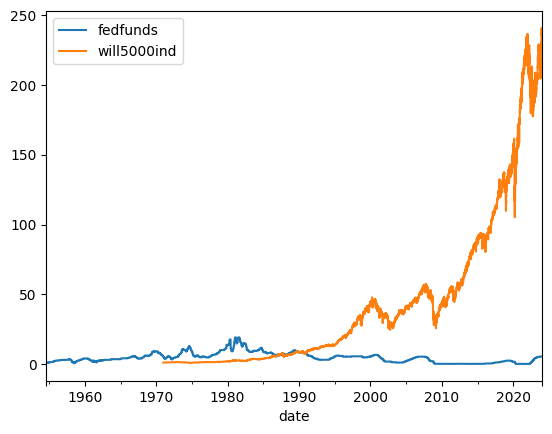

In [12]:
combined_data.plot()

In [13]:
fed_funds_rate = combined_data['fedfunds'].copy()

In [14]:
fed_funds_rate = fed_funds_rate.resample('MS').first()
fed_funds_rate = fed_funds_rate.round(2)

In [15]:
number_of_months = int(12*2.1)

fed_funds_rate_rolling_max = fed_funds_rate.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_reversed = fed_funds_rate.iloc[::-1]
fed_funds_rate_rolling_max_forward_reversed = fed_funds_rate_reversed.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_rolling_max_forward = fed_funds_rate_rolling_max_forward_reversed.iloc[::-1]

fed_funds_rate_peaks = fed_funds_rate[(fed_funds_rate == fed_funds_rate_rolling_max) & (fed_funds_rate == fed_funds_rate_rolling_max_forward)]

In [16]:
fed_funds_rate_peaks = pd.DataFrame(fed_funds_rate_peaks)
fed_funds_rate_peaks.columns = ['peaks']
fed_funds_rate_peaks['peaks'] = fed_funds_rate_peaks['peaks'].astype('float64')

fed_funds_rate_peaks = fed_funds_rate_peaks[fed_funds_rate_peaks['peaks'].notnull()]
fed_funds_rate_peaks

,peaks
date,
1959-12-01,4.00
1969-09-01,9.19
1974-08-01,12.92
1981-07-01,19.10
1984-09-01,11.64
1989-04-01,9.85
1995-05-01,6.05
1998-02-01,5.56
2000-08-01,6.54


In [17]:
mask = pd.Series([False] * len(fed_funds_rate_peaks), index=fed_funds_rate_peaks.index)

for i in range(len(fed_funds_rate_peaks)):
    if i == 0 or fed_funds_rate_peaks['peaks'].iloc[i] != fed_funds_rate_peaks['peaks'].iloc[i-1]:
        mask.iloc[i] = True

result_df = fed_funds_rate_peaks[mask]

result_df

,peaks
date,
1959-12-01,4.00
1969-09-01,9.19
1974-08-01,12.92
1981-07-01,19.10
1984-09-01,11.64
1989-04-01,9.85
1995-05-01,6.05
1998-02-01,5.56
2000-08-01,6.54


In [18]:
# now that we have the peak dates, create a dataframe with a column for the date of the wilshire 5000 index value, the wilshire 5000 index value, the peak fed funds rate, and the peak fed funds rate date. 

wilshire_5000 = combined_data['will5000ind'].copy()

wilshire_5000 = wilshire_5000.resample('MS').first()

wilshire_5000 = wilshire_5000.round(2)

wilshire_5000 = pd.DataFrame(wilshire_5000)

wilshire_5000.columns = ['wilshire_5000']

wilshire_5000 = wilshire_5000[wilshire_5000['wilshire_5000'].notnull()]

wilshire_5000

,wilshire_5000
date,
1970-12-01,1.00
1971-01-01,1.00
1971-02-01,1.05
1971-03-01,1.07
1971-04-01,1.12
...,...
2023-09-01,225.48
2023-10-01,214.04
2023-11-01,210.35


In [19]:
wilshire_5000 = wilshire_5000.merge(result_df, how='left', left_index=True, right_index=True)

wilshire_5000['peak_fed_funds_rate_date'] = wilshire_5000.index

wilshire_5000['peak_fed_funds_rate_date'] = wilshire_5000['peak_fed_funds_rate_date'].where(wilshire_5000['peaks'].notnull(), other=None)

wilshire_5000['peaks'] = wilshire_5000['peaks'].fillna(method='ffill', limit=24)

wilshire_5000['peak_fed_funds_rate_date'] = wilshire_5000['peak_fed_funds_rate_date'].fillna(method='ffill', limit=24)

wilshire_5000 = wilshire_5000[wilshire_5000['peaks'].notnull()]

wilshire_5000['wilshire_5000_pct_change'] = wilshire_5000.groupby('peak_fed_funds_rate_date')['wilshire_5000'].pct_change()+1

wilshire_5000['wilshire_5000_pct_change'] = wilshire_5000['wilshire_5000_pct_change'].fillna(1)

wilshire_5000

/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_78579/469512814.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wilshire_5000['peaks'] = wilshire_5000['peaks'].fillna(method='ffill', limit=24)
/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_78579/469512814.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wilshire_5000['peak_fed_funds_rate_date'] = wilshire_5000['peak_fed_funds_rate_date'].fillna(method='ffill', limit=24)


,wilshire_5000,peaks,peak_fed_funds_rate_date,wilshire_5000_pct_change
date,,,,
1974-08-01,0.92,12.92,1974-08-01,1.000000
1974-09-01,0.84,12.92,1974-08-01,0.913043
1974-10-01,0.74,12.92,1974-08-01,0.880952
1974-11-01,0.87,12.92,1974-08-01,1.175676
1974-12-01,0.83,12.92,1974-08-01,0.954023
...,...,...,...,...
2023-09-01,225.48,5.33,2023-09-01,1.000000
2023-10-01,214.04,5.33,2023-09-01,0.949264
2023-11-01,210.35,5.33,2023-09-01,0.982760


In [20]:
wilshire_5000 = wilshire_5000[['peak_fed_funds_rate_date','wilshire_5000_pct_change']]
wilshire_5000

,peak_fed_funds_rate_date,wilshire_5000_pct_change
date,,
1974-08-01,1974-08-01,1.000000
1974-09-01,1974-08-01,0.913043
1974-10-01,1974-08-01,0.880952
1974-11-01,1974-08-01,1.175676
1974-12-01,1974-08-01,0.954023
...,...,...
2023-09-01,2023-09-01,1.000000
2023-10-01,2023-09-01,0.949264
2023-11-01,2023-09-01,0.982760


In [21]:
wilshire_5000['rownumber'] = wilshire_5000.groupby('peak_fed_funds_rate_date').cumcount()
wilshire_5000

/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_78579/3808454576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wilshire_5000['rownumber'] = wilshire_5000.groupby('peak_fed_funds_rate_date').cumcount()


,peak_fed_funds_rate_date,wilshire_5000_pct_change,rownumber
date,,,
1974-08-01,1974-08-01,1.000000,0
1974-09-01,1974-08-01,0.913043,1
1974-10-01,1974-08-01,0.880952,2
1974-11-01,1974-08-01,1.175676,3
1974-12-01,1974-08-01,0.954023,4
...,...,...,...
2023-09-01,2023-09-01,1.000000,0
2023-10-01,2023-09-01,0.949264,1
2023-11-01,2023-09-01,0.982760,2


In [22]:
wilshire_5000['cumulative_product'] = wilshire_5000.groupby('peak_fed_funds_rate_date')['wilshire_5000_pct_change'].cumprod()
wilshire_5000

,peak_fed_funds_rate_date,wilshire_5000_pct_change,rownumber,cumulative_product
date,,,,
1974-08-01,1974-08-01,1.000000,0,1.000000
1974-09-01,1974-08-01,0.913043,1,0.913043
1974-10-01,1974-08-01,0.880952,2,0.804348
1974-11-01,1974-08-01,1.175676,3,0.945652
1974-12-01,1974-08-01,0.954023,4,0.902174
...,...,...,...,...
2023-09-01,2023-09-01,1.000000,0,1.000000
2023-10-01,2023-09-01,0.949264,1,0.949264
2023-11-01,2023-09-01,0.982760,2,0.932899


In [23]:
wilshire_5000 = wilshire_5000.pivot(index='rownumber', columns='peak_fed_funds_rate_date', values='cumulative_product')
wilshire_5000

peak_fed_funds_rate_date,1974-08-01,1981-07-01,1984-09-01,1989-04-01,1995-05-01,1998-02-01,2000-08-01,2007-03-01,2019-05-01,2023-09-01
rownumber,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.913043,1.003922,0.991758,1.048980,1.036521,1.072666,1.073563,1.013685,0.941675,0.949264
2,0.804348,0.952941,1.005495,1.096599,1.067729,1.134465,1.020000,1.056696,1.014563,0.932899
3,0.945652,0.894118,0.989011,1.085714,1.106242,1.147029,0.993793,1.097556,1.012172,1.019070
4,0.902174,0.941176,1.013736,1.165986,1.126162,1.105942,0.903448,1.075269,1.001304,1.064130
5,0.880435,0.984314,1.096154,1.204082,1.165339,1.161290,0.914943,1.044379,1.006521,NaN
6,1.010870,0.956863,1.129121,1.195918,1.158699,1.123260,0.954023,1.053177,1.052746,NaN
7,1.076087,0.909804,1.120879,1.164626,1.204515,0.980985,0.860230,1.106158,1.080496,NaN
8,1.097826,0.882353,1.107143,1.193197,1.221780,0.977929,0.802069,1.082698,1.112158,NaN


In [24]:
wilshire_5000.columns = pd.to_datetime(wilshire_5000.columns, format='%B %Y')
wilshire_5000 = wilshire_5000.reindex(sorted(wilshire_5000.columns), axis=1)
wilshire_5000

peak_fed_funds_rate_date,1974-08-01,1981-07-01,1984-09-01,1989-04-01,1995-05-01,1998-02-01,2000-08-01,2007-03-01,2019-05-01,2023-09-01
rownumber,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.913043,1.003922,0.991758,1.048980,1.036521,1.072666,1.073563,1.013685,0.941675,0.949264
2,0.804348,0.952941,1.005495,1.096599,1.067729,1.134465,1.020000,1.056696,1.014563,0.932899
3,0.945652,0.894118,0.989011,1.085714,1.106242,1.147029,0.993793,1.097556,1.012172,1.019070
4,0.902174,0.941176,1.013736,1.165986,1.126162,1.105942,0.903448,1.075269,1.001304,1.064130
5,0.880435,0.984314,1.096154,1.204082,1.165339,1.161290,0.914943,1.044379,1.006521,NaN
6,1.010870,0.956863,1.129121,1.195918,1.158699,1.123260,0.954023,1.053177,1.052746,NaN
7,1.076087,0.909804,1.120879,1.164626,1.204515,0.980985,0.860230,1.106158,1.080496,NaN
8,1.097826,0.882353,1.107143,1.193197,1.221780,0.977929,0.802069,1.082698,1.112158,NaN


In [25]:
wilshire_5000.columns = wilshire_5000.columns.strftime('%B %Y')
wilshire_5000

peak_fed_funds_rate_date,August 1974,July 1981,September 1984,April 1989,May 1995,February 1998,August 2000,March 2007,May 2019,September 2023
rownumber,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.913043,1.003922,0.991758,1.048980,1.036521,1.072666,1.073563,1.013685,0.941675,0.949264
2,0.804348,0.952941,1.005495,1.096599,1.067729,1.134465,1.020000,1.056696,1.014563,0.932899
3,0.945652,0.894118,0.989011,1.085714,1.106242,1.147029,0.993793,1.097556,1.012172,1.019070
4,0.902174,0.941176,1.013736,1.165986,1.126162,1.105942,0.903448,1.075269,1.001304,1.064130
5,0.880435,0.984314,1.096154,1.204082,1.165339,1.161290,0.914943,1.044379,1.006521,NaN
6,1.010870,0.956863,1.129121,1.195918,1.158699,1.123260,0.954023,1.053177,1.052746,NaN
7,1.076087,0.909804,1.120879,1.164626,1.204515,0.980985,0.860230,1.106158,1.080496,NaN
8,1.097826,0.882353,1.107143,1.193197,1.221780,0.977929,0.802069,1.082698,1.112158,NaN


In [26]:
wilshire_5000 = wilshire_5000 - 1
wilshire_5000 = wilshire_5000.round(4)
wilshire_5000 = wilshire_5000.rename(columns={'rownumber':'months_since_peak'})
wilshire_5000

peak_fed_funds_rate_date,August 1974,July 1981,September 1984,April 1989,May 1995,February 1998,August 2000,March 2007,May 2019,September 2023
rownumber,,,,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0870,0.0039,-0.0082,0.0490,0.0365,0.0727,0.0736,0.0137,-0.0583,-0.0507
2,-0.1957,-0.0471,0.0055,0.0966,0.0677,0.1345,0.0200,0.0567,0.0146,-0.0671
3,-0.0543,-0.1059,-0.0110,0.0857,0.1062,0.1470,-0.0062,0.0976,0.0122,0.0191
4,-0.0978,-0.0588,0.0137,0.1660,0.1262,0.1059,-0.0966,0.0753,0.0013,0.0641
5,-0.1196,-0.0157,0.0962,0.2041,0.1653,0.1613,-0.0851,0.0444,0.0065,NaN
6,0.0109,-0.0431,0.1291,0.1959,0.1587,0.1233,-0.0460,0.0532,0.0527,NaN
7,0.0761,-0.0902,0.1209,0.1646,0.2045,-0.0190,-0.1398,0.1062,0.0805,NaN
8,0.0978,-0.1176,0.1071,0.1932,0.2218,-0.0221,-0.1979,0.0827,0.1122,NaN


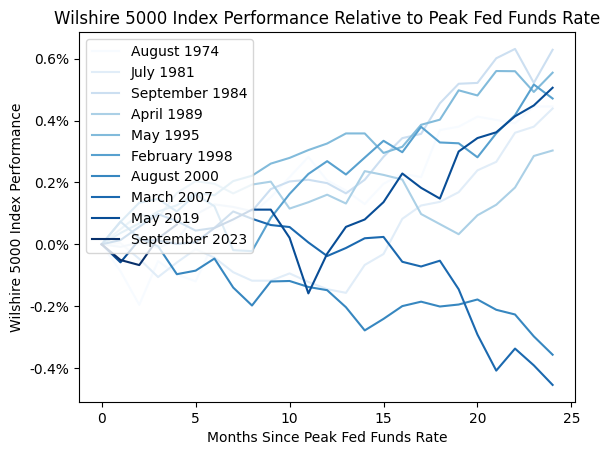

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

wilshire_5000.plot(colormap='Blues', legend=False)

plt.title('Wilshire 5000 Index Performance Relative to Peak Fed Funds Rate')
plt.xlabel('Months Since Peak Fed Funds Rate')
plt.ylabel('Wilshire 5000 Index Performance')
plt.legend(loc='upper left')

fmt = '%.1f%%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

plt.show()

In [28]:
index_return_data = combined_data['will5000ind'].copy()

index_return_data = index_return_data.resample('MS').first()

index_return_data.dropna(inplace=True)
index_return_data = pd.DataFrame(index_return_data)
index_return_data.reset_index(inplace=True)
index_return_data

,date,will5000ind
0,1970-12-01,1.00
1,1971-01-01,1.00
2,1971-02-01,1.05
3,1971-03-01,1.07
4,1971-04-01,1.12
...,...,...
633,2023-09-01,225.48
634,2023-10-01,214.04
635,2023-11-01,210.35
636,2023-12-01,229.78


In [29]:
new_dataframe = pd.DataFrame()

for i in range(len(index_return_data)):
    if i + 24 < len(index_return_data):
        temp_dataframe = index_return_data.iloc[i:i+25].copy()
        temp_dataframe['beginning_date'] = index_return_data['date'].iloc[i]
        temp_dataframe['beginning_value'] = index_return_data['will5000ind'].iloc[i]
        new_dataframe = pd.concat([new_dataframe, temp_dataframe], ignore_index=True)

new_dataframe['row_number'] = new_dataframe.groupby('beginning_date')['date'].cumcount()

new_dataframe['cumulative_product'] = new_dataframe['will5000ind']/new_dataframe['beginning_value']

new_dataframe

,date,will5000ind,beginning_date,beginning_value,row_number,cumulative_product
0,1970-12-01,1.00,1970-12-01,1.00,0,1.000000
1,1971-01-01,1.00,1970-12-01,1.00,1,1.000000
2,1971-02-01,1.05,1970-12-01,1.00,2,1.050000
3,1971-03-01,1.07,1970-12-01,1.00,3,1.070000
4,1971-04-01,1.12,1970-12-01,1.00,4,1.120000
...,...,...,...,...,...,...
15345,2023-09-01,225.48,2022-01-01,234.96,20,0.959653
15346,2023-10-01,214.04,2022-01-01,234.96,21,0.910964
15347,2023-11-01,210.35,2022-01-01,234.96,22,0.895259
15348,2023-12-01,229.78,2022-01-01,234.96,23,0.977954


In [30]:
average_cumulative_product = new_dataframe.groupby('row_number')['cumulative_product'].mean()-1
average_cumulative_product


row_number
0     0.000000
1     0.009902
2     0.019920
3     0.029905
4     0.039850
5     0.049825
6     0.059768
7     0.069869
8     0.080067
9     0.090306
10    0.100599
11    0.111184
12    0.121830
13    0.132682
14    0.143337
15    0.153897
16    0.164631
17    0.175513
18    0.186534
19    0.197580
20    0.208732
21    0.219855
22    0.230866
23    0.241987
24    0.253277
Name: cumulative_product, dtype: float64

In [31]:
combined_df = pd.concat([wilshire_5000, average_cumulative_product], axis=1)
combined_df.rename(columns={'cumulative_product':'Mean cumulative return over period'}, inplace=True)
combined_df

,August 1974,July 1981,September 1984,April 1989,May 1995,February 1998,August 2000,March 2007,May 2019,September 2023,Mean cumulative return over period
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000
1,-0.0870,0.0039,-0.0082,0.0490,0.0365,0.0727,0.0736,0.0137,-0.0583,-0.0507,0.009902
2,-0.1957,-0.0471,0.0055,0.0966,0.0677,0.1345,0.0200,0.0567,0.0146,-0.0671,0.019920
3,-0.0543,-0.1059,-0.0110,0.0857,0.1062,0.1470,-0.0062,0.0976,0.0122,0.0191,0.029905
4,-0.0978,-0.0588,0.0137,0.1660,0.1262,0.1059,-0.0966,0.0753,0.0013,0.0641,0.039850
5,-0.1196,-0.0157,0.0962,0.2041,0.1653,0.1613,-0.0851,0.0444,0.0065,NaN,0.049825
6,0.0109,-0.0431,0.1291,0.1959,0.1587,0.1233,-0.0460,0.0532,0.0527,NaN,0.059768
7,0.0761,-0.0902,0.1209,0.1646,0.2045,-0.0190,-0.1398,0.1062,0.0805,NaN,0.069869
8,0.0978,-0.1176,0.1071,0.1932,0.2218,-0.0221,-0.1979,0.0827,0.1122,NaN,0.080067
9,0.1522,-0.1176,0.1786,0.2027,0.2610,0.0852,-0.1202,0.0624,0.1122,NaN,0.090306
